In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

sys.path.append('../src')
from vae_lightning_utils import VAE
from dataset_utils import get_dataset, visualize_dataset


In [2]:
# Load dataset
train_loader, test_loader, image_shape = get_dataset('mnist_rotated', 1, 0, data_base_dir='../data/')


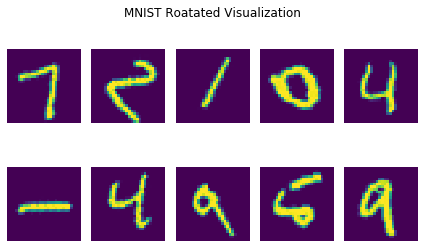

In [3]:
# Visualize dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.arange(0, 10)):
    img = visualize_dataset(test_loader, dataset_index=i, image_shape=image_shape)
    ax.imshow(img)
    ax.set_axis_off()
fig.suptitle("MNIST Roatated Visualization")
plt.tight_layout()
plt.show()


## Inference using VAE

In [4]:
vae_mnist_config = r'../configs/vae_mnist.yaml'


# Define the encoder decoder class
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


with open(vae_mnist_config) as f:
    hparams_dict = yaml.safe_load(f)
hparams = AttrDict()
hparams.update(hparams_dict)
vae_model = VAE(hparams, train_loader, test_loader)


In [5]:
# Load pretrained model
encoder_pretrained_path = '../models/vae_mnist_rotated_encoder.pth'
decoder_pretrained_path = '../models/vae_mnist_rotated_decoder.pth'

vae_model.p_net.load_state_dict(torch.load(encoder_pretrained_path, map_location=lambda storage, loc: storage))
vae_model.q_net.load_state_dict(torch.load(decoder_pretrained_path, map_location=lambda storage, loc: storage))


<All keys matched successfully>

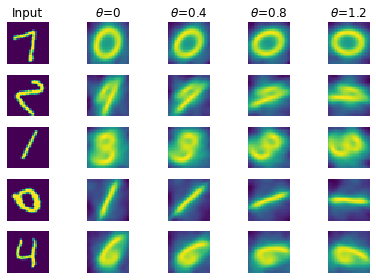

In [29]:
trainset_idxs = [10, 20, 30, 40, 50]
theta_inputs = [0, 0.4, 0.8, 1.2]

fig, axs = plt.subplots(len(trainset_idxs), len(theta_inputs) + 1)

for i, idx in enumerate(trainset_idxs):
    # Get input
    y = test_loader.dataset[idx][0].unsqueeze(0)

    # Visualize it
    ax = axs[i, 0]
    ax.imshow(visualize_dataset(test_loader, idx, image_shape))
    ax.set_axis_off()

    for j, theta_input in enumerate(theta_inputs):
        # Inference
        y_hat = vae_model.forward(vae_model.x_coord, y, theta_input=theta_input)[0].detach().numpy()
        y_hat = y_hat.reshape(image_shape, image_shape)

        # Visualize prediction
        ax = axs[i, j + 1]
        ax.imshow(y_hat)
        ax.set_axis_off()

axs[0, 0].set_title('Input')
for ax, theta_input in zip(axs[0][1:], theta_inputs):
    ax.set_title(r'$\theta$={}'.format(theta_input))

plt.tight_layout()
plt.show()
